# Description 

Product availabilty per lake

This script allows to show the availbility of key varaibles for a given lake during a selected period of time in the lakes_cci dataset. This script is useful for checking whether data on a target lake is available for further downloading.


INPUT:
    <ul>
    <li>The identifier of the lake. The id of the lake is indicated 
      in the csv file containing lake metadata. This file is available 
      at the project website:
        https://climate.esa.int/documents/1857/lakescci_v2.0.2_data-availability_gQHtOE6.csv</li>
    <li>Land mask: the netCDF file containing the mask of the lakes in CCI dataset this file 
      is part of the dataset and is available at:
      https://dap.ceda.ac.uk/neodc/esacci/lakes/data/lake_products/L3S/v2.0.1/ESA_CCI_static_lake_mask_v2.0.1.nc</li>
    <li>first/last date</li>
    <li>version of the dataset (default value 2.0.1)</li>
    <li>name of the png file to save the figure with data availabily </li>
    </ul>

Reference: Carrea, L.; Crétaux, J.-F.; Liu, X.; Wu, Y.; Bergé-Nguyen, M.; Calmettes, B.; Duguay, C.; Jiang, D.; Merchant, C.J.; Mueller, D.; Selmes, N.; Simis, S.; Spyrakos, E.; Stelzer, K.; Warren, M.; Yesou, H.; Zhang, D. (2022): ESA Lakes Climate Change Initiative (Lakes_cci): Lake products, Version 2.0.1. NERC EDS Centre for Environmental Data Analysis, date of citation.

http://dx.doi.org/10.5285/a07deacaffb8453e93d57ee214676304

If you find a bug, have a question or a suggestion, don't hesitate to contact us, it will be much appreciated : cci_lakes.contact@groupcls.com

In [18]:
import os
import numpy as np
import xarray as xr 
import datetime
import netCDF4 as nc
import pandas as pd
import pylab as pl
%matplotlib widget

# Step 1: Define input parameters. 

In this exemple, we analyse data over Lake Naivasha (Kenya).

The identifier (1659) was obtained from  the csv file (https://climate.esa.int/documents/2154/lakes_cci_v2.0.2_product_availability.csv) available in the project website: (https://climate.esa.int/fr/projects/lakes/) 

The script execution time may be very lon depending on the time period defined. The reason for this is thal 
all the files in the period must be read in order to check the availability of the multiple variables in each 
file.
  
In our case, we are looking for data from 2012-01-01 to 2012-03-31

In [125]:
###########################################################################################
# input parameters
###########################################################################################   

# lakes mask file 
maskfile = 'ESA_CCI_static_lake_mask_v2.0.1.nc'

# Id for lake Naivasha
lake_id = 1659

# defining the period of time in string format: YYYY-MM-DD
# dates values must be between 1992-09-26 and 2020-12-31
mindate = '2012-01-01'
maxdate = '2012-03-31'

# version dataset (2.0.2 is the version published in July 2022)
version = '2.0.2'

# output
pngfile = f'output/Naivisha_coverage_{mindate}_{maxdate}.png'

In [119]:
# test if dates are in the temporal coverage

mindate = datetime.datetime.strptime(mindate, '%Y-%m-%d')
maxdate = datetime.datetime.strptime(maxdate, '%Y-%m-%d')
mindate = max([mindate, datetime.datetime(1992,9,26)])
maxdate = min([maxdate, datetime.datetime(2020,12,31)])

# Step 2: zone selection

In this step, latitude and longitude values inside the lake are obtained from the lake mask file. The boundary values will then be used to read the data in the region covering the lake.

In [23]:

###################################################################
# create mask base on lake_id
###################################################################

mask_nc = nc.Dataset(maskfile)

mask_ind  = np.where(mask_nc.variables['CCI_lakeid'][:] == lake_id)
minx = np.min(mask_ind[1][:]) - 1
maxx = np.max(mask_ind[1][:]) + 1

miny = np.min(mask_ind[0][:]) - 1
maxy = np.max(mask_ind[0][:]) + 1

mask_lake = mask_nc.variables['CCI_lakeid'][miny:maxy+1, minx:maxx+1].data
mask_lake[mask_lake!=lake_id] = 0
mask_lake[mask_lake == lake_id] = 1

lat = mask_nc.variables['lat'][miny:maxy+1]
lon = mask_nc.variables['lon'][minx:maxx+1]

mask_nc.close()


A good validation test is to check that the lake ID is correct by visualising the lake mask.


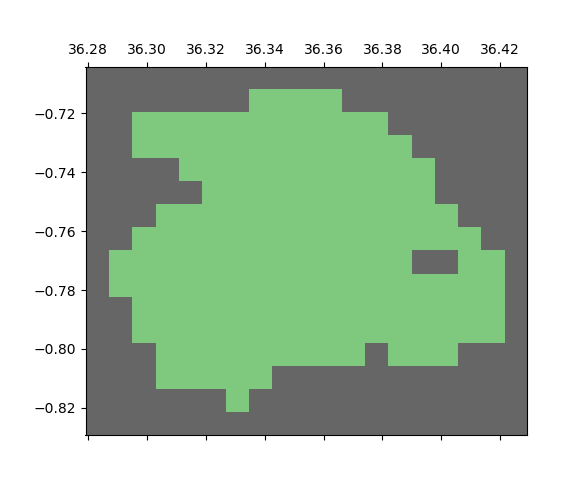

In [41]:
# plot lake mask 
cmap = pl.set_cmap('Accent_r')
pl.matshow(mask_lake, extent=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)])


# Step 3: Data availability

In this step, each daily file in the defined period is read to get the availabily of the variables. 

Key variables from the main products in the data lakes_cci dataset (LWL, LWE, LSWT, LIC and LWLR) are analysed.

If you are interested in a subset of the variables, you can modified the 'key_variables' list and the script will run faster. 



In [120]:
# list of key variables
key_variables = ['water_surface_height_above_reference_datum',
                 'lake_surface_water_extent', 
                 'lake_surface_water_temperature',
                 'lake_ice_cover_class',
                 'chla_mean', 'turbidity_mean']

for xxx in [400, 412, 443, 469, 488, 490, 510, 531, 547, 555, 560, 620, 645, 665, 667, 
            674, 678, 681, 709, 748, 754, 760, 764, 767, 779, 859, 865, 869, 885, 900, 
            940, 1012] :
    key_variables.append(f'Rw{xxx}')
    

In [121]:
# a dataframe containing a column per key variable is defined
data_availability = pd.DataFrame(columns = ['time'] + key_variables)

In [122]:
# The data availability process

for data_date in np.arange(mindate.toordinal(), maxdate.toordinal()+1):
    current_date = datetime.datetime.fromordinal(data_date)
    date_str = current_date.strftime("%Y%m%d")
    
    next_row = len(data_availability)
    data_availability.at[next_row , 'time' ] = current_date
    
    
    #print (f'reading data from lake_id {lake_id} -  ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.nc')

    path  = f'https://data.cci.ceda.ac.uk/thredds/dodsC/esacci/lakes/data/lake_products/L3S/v{version}/'
    path += f'{current_date.year}/{current_date.month:02}/'
    path += f'ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.nc'

    dataset = xr.open_dataset(path)
    dataset = dataset.isel(lat=slice(miny, maxy+1), lon=slice(minx, maxx+1))


    # apply mask     
    for var in key_variables:
        if var in dataset.keys():
            filval = dataset[var].encoding['_FillValue']
            data = dataset[var][0,:,:].values
            data[mask_lake == 0] = filval
            # only for float variables
            if dataset[var].dtype == 'float32':
                data[np.isnan(data)] =  filval

            data_availability.at[next_row , var ] = (np.min(data) != np.max(data))
        else:
            data_availability.at[next_row , var ] = False
            
data_availability = data_availability.set_index('time')

# Step 4: Visualising data availability

In this step, a plot indicating data is available (in green) or unavailable (in gray) is generated.

The name of some variables is modified for cosmetic reasons, to avoid very long string affecting plot visualisation 


In [123]:
# this change is only for cosmetic reasons, to avoid very long string affecting plot visualisation 
data_availability = data_availability.rename(columns = {'water_surface_height_above_reference_datum': 'LWL' ,
                          'lake_surface_water_extent': 'LWE',
                          'lake_surface_water_temperature': 'LSWT',
                          'chla_mean': 'CHLA',
                          'turbidity_mean' : 'Turbidity',
                          'lake_ice_cover_class': 'LIC'})



[Text(20, 0, '2012-01-21'),
 Text(40, 0, '2012-02-10'),
 Text(60, 0, '2012-03-01'),
 Text(80, 0, '2012-03-21')]

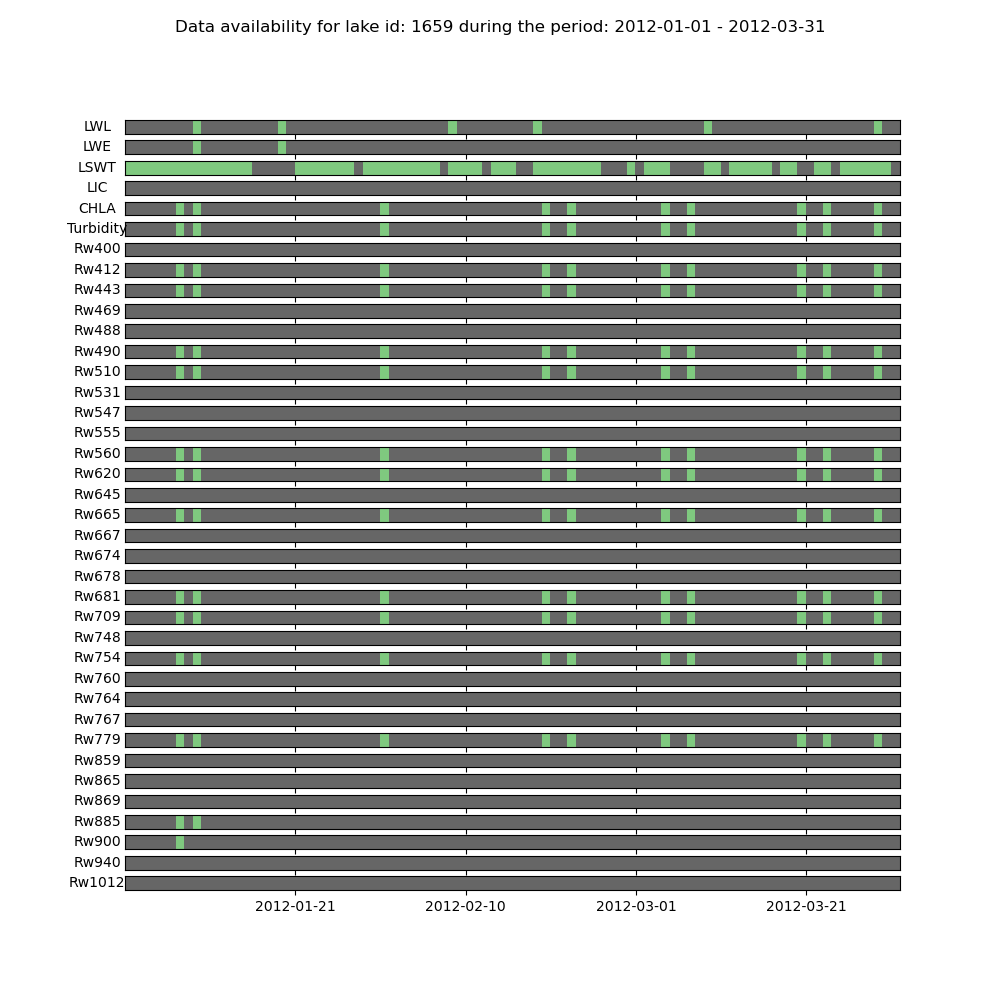

In [124]:
pl.close()
pl.rcParams ['figure.max_open_warning'] = len(data_availability.columns)
fig, axs = pl.subplots(nrows=len(data_availability.columns), ncols = 1, figsize = (10,10), sharex = True)
pl.subplots_adjust(hspace=0.5)
cmap = pl.set_cmap('Accent_r')

str_mindate = mindate.date().strftime('%Y-%m-%d')
str_maxdate = maxdate.date().strftime('%Y-%m-%d')
pl.suptitle (f'Data availability for lake id: {lake_id} during the period: {str_mindate} - {str_maxdate}')

for var, ax in zip(data_availability.columns, axs.ravel()):
    pl.axes(ax)
    pl.pcolor([list(data_availability[var].values)])
    pl.ylabel(var, rotation = 0, labelpad=20, va = 'center')
    pl.yticks([])
    
xt = np.int16(pl.xticks()[0][1:-1])
pl.gca().set_xticks(xt)
pl.gca().set_xticklabels(data_availability.index.strftime('%Y-%m-%d')[xt])


The file can be saved to keep data availability information

In [364]:
pl.savefig(pngfile, bbox_inches = 'tight', dpi=1000)